# Analysis on Titanic dataset
## Quick Introduction to the dataset
This dataset contains demographics and passenger information from 891 of the 2224 passengers and crew on board the Titanic. Accoding to [the Kaggle website](https://www.kaggle.com/c/titanic/data), where the data was originally obtained, the variables are defined as follows:
```
VARIABLE DESCRIPTIONS:
survival        Survival
                (0 = No; 1 = Yes)
pclass          Passenger Class
                (1 = 1st; 2 = 2nd; 3 = 3rd)
name            Name
sex             Sex
age             Age
sibsp           Number of Siblings/Spouses Aboard
parch           Number of Parents/Children Aboard
ticket          Ticket Number
fare            Passenger Fare
cabin           Cabin
embarked        Port of Embarkation
                (C = Cherbourg; Q = Queenstown; S = Southampton)
```              








## Data Wrangling


### Data Acquisition
Since the dataset was provided as a CSV format, let's load the data using Pandas.
Note that I locataed the dataset CSV file under the subdirectory of this Notebook `./dataset/titanic` and filename is `titanic-data.csv`. 

In [203]:
import numpy as np
import pandas as pd
import seaborn as sns
from __future__ import division
%matplotlib inline

# read csv file
rawData = pd.read_csv('./dataset/titanic/titanic-data.csv') # a relative directory
rawData.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Data Cleaning


#### Estimated Ages
First of all, according to [the Kaggle site](https://www.kaggle.com/c/titanic/data), the age is written in the form xx.5 if the age is estimated. While this information whether the age is estimated or not would be valuable for further analysis, the way they use could skew any statistics. So let's see how many we have those estimated ages and separate them out as another column. 


In [204]:
# we can use modular operation with 1 over the ages to find xx.5 formed entries. 
# as the following code, the operation should give you True when an entry is xx.5 form, otherwise False.
def checkIfAgeWasEstimated(ages):
    mod = ages % 1
    return pd.DataFrame({'IsAgeEstimated': (mod == 0.5), 'Age': ages})
    
# verifying the method with small testset
testset = pd.Series(np.array([11.5, 11.0, 35, 35.0, 35.5]))
checkIfAgeWasEstimated(testset)

,Age,IsAgeEstimated
0,11.5,True
1,11.0,False
2,35.0,False
3,35.0,False
4,35.5,True


In [205]:
IsAgeEstimated = checkIfAgeWasEstimated(rawData['Age'])
IsAgeEstimated.sum()  # as sum() treats True as 1 and False as 0, this effectively counts number of `True`s.

Age               21205.17
IsAgeEstimated       18.00
dtype: float64

So we have total 18 entries of ages that are estimated. Let's see them. 

In [206]:
ageEstimatedOnly = IsAgeEstimated.loc[IsAgeEstimated['IsAgeEstimated'] == True]
print ageEstimatedOnly

print ''
print ageEstimatedOnly.describe()

      Age IsAgeEstimated
57   28.5           True
111  14.5           True
116  70.5           True
122  32.5           True
123  32.5           True
148  36.5           True
152  55.5           True
153  40.5           True
203  45.5           True
227  20.5           True
296  23.5           True
331  45.5           True
525  40.5           True
676  24.5           True
735  28.5           True
767  30.5           True
814  30.5           True
843  34.5           True

             Age
count  18.000000
mean   35.277778
std    13.224556
min    14.500000
25%    28.500000
50%    32.500000
75%    40.500000
max    70.500000


Let's add the column as `IsAgeEstimated` with boolean types. 

In [207]:
rawData['IsAgeEstimated'] = IsAgeEstimated['IsAgeEstimated']
rawData.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,IsAgeEstimated
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,False
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,False
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,False
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,False
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,False


Now we need to round down the `Age` column so that it does not contains xx.5 forms. 

In [208]:
import math 

rawData['Age'] = rawData['Age'].apply(math.ceil)  # applying math.ceil() method against 'Age' column and reassign them. 

In [209]:
# verifying two known former estimated ages
print rawData['Age'][57]
print rawData['Age'][148]

29.0
37.0


Good! Those estimated ages are rounded down as we intended.

#### Missing Values
While cleaning estimated ages above, I also realized that there are missing values in `Age` column. In fact, not only `Age` column, but there are other columns I was able to find many missing values, e.g. `Cabin`, `Embarked`, and probably more. Let's start with identifying what columns have missing values. 

In [210]:
# isnull() method checks each cells and returns True if a cell is empty(NaN), otherwise returns False.
# again, sum() method will treat Trus as 1 and False as 0, so sum() effectively counts number of True entries.
rawData.isnull().sum()

PassengerId         0
Survived            0
Pclass              0
Name                0
Sex                 0
Age               177
SibSp               0
Parch               0
Ticket              0
Fare                0
Cabin             687
Embarked            2
IsAgeEstimated      0
dtype: int64

As you can see above, we have 177 missing values among `Age` column, 687 missing values among `Cabin` column, and 2 missing values from `Embarked` column. For `Cabin` and `Embarked` columns, both are not containing numerical values thus we can simple consider those missing values as `Unknown`, meaning the information about what their cabin were or where they embarked is simply unknown. For readability, let's replace those `NaN`s to `Unknown`.

In [211]:
# Let's write a method to convert NaN to 'Unknown' for vectorized operation. 
def nanToUnknown(value):
    try:
        if math.isnan(value):
            return 'Unknown'
    except:
        return value
    return value

In [212]:
# Testing the method with single data
# Cabin's [0] is NaN, [1] is valid value.
# [0] should now be 'Unknown'
print nanToUnknown(rawData['Cabin'][0])    
print nanToUnknown(rawData['Cabin'][1])

Unknown
C85


In [213]:
# Good. Now applying vectorized operation.
rawData['Cabin'] = rawData['Cabin'].apply(nanToUnknown)
rawData['Cabin'].isnull().sum()   # this should be 0 now. 


0

Good. Now do the same thing for `Embarked` column.

In [214]:
print 'Before applying: {0}'.format(rawData['Embarked'].isnull().sum())
rawData['Embarked'] = rawData['Embarked'].apply(nanToUnknown)
print 'After applying: {0}'.format(rawData['Embarked'].isnull().sum())

Before applying: 2
After applying: 0


Now, for `Age` column, since these are supposed to be numerical values those missing values need to be handled properly. While there are many approaches to handle missing values in data science [link](http://www.datasciencecentral.com/profiles/blogs/how-to-treat-missing-values-in-your-data-1), here I will delete those entries(listwise deletion: rows containing missing variables are deleted) for simplicity. 

In [215]:
missngAges = rawData['Age'].isnull()
cleanedData = rawData[missngAges == False]   # taking only the rows with non missing ages
cleanedData.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,IsAgeEstimated
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Unknown,S,False
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,False
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Unknown,S,False
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,False
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Unknown,S,False
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,False
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,Unknown,S,False
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,Unknown,S,False
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,Unknown,C,False
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S,False


You can see that the row with index 5 has been removed in `cleanedData`. 

In [216]:
print 'rawData count: {0}'.format(rawData['PassengerId'].count())
print 'cleanData count: {0}'.format(cleanedData['PassengerId'].count())

rawData count: 891
cleanData count: 714


Since we had 177 missing age rows in `rawData`, above result seems to be as we intended ($891-714=177$).

## Data Exploration
DELETE -  *Is the data explored in many ways?*
The project investigates the stated question(s) from multiple angles. At least three variables are investigated using both single-variable (1d) and multiple-variable (2d) explorations.
*Are there a variety of relevant visualizations and statistical summaries?*
  - The project's visualizations are varied and show multiple comparisons and trends. Relevant statistics are computed throughout the analysis when an inference is made about the data.
  - At least two kinds of plots should be created as part of the explorations.



Now we have cleaned the data, let's explore the dataset. 

In [217]:
cleanedData.columns

Index([u'PassengerId', u'Survived', u'Pclass', u'Name', u'Sex', u'Age',
       u'SibSp', u'Parch', u'Ticket', u'Fare', u'Cabin', u'Embarked',
       u'IsAgeEstimated'],
      dtype='object')

### Number of Passengers Survived vs Not Survived

How many people survived? What is the ratio between survived and not survived passengers? 

In [218]:
total = cleanedData['Survived'].describe()['count']
survived_count = cleanedData['Survived'].value_counts()
print 'Among total {0} passengers,'.format(total)
print '{0} survived, and {1} not.'.format(survived_count[1], survived_count[0])
print 'Survived ratio: {0}'.format(survived_count[1] / total)
print 'Nonsurvived ratio: {0}'.format(survived_count[0] / total)

Among total 714.0 passengers,
290 survived, and 424 not.
Survived ratio: 0.406162464986
Nonsurvived ratio: 0.593837535014


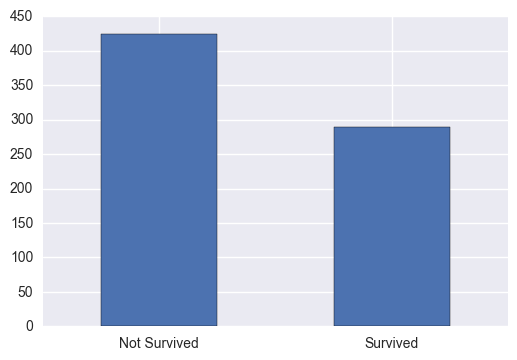

In [219]:
survived_count.index = ['Not Survived', 'Survived']
survived_count.plot(kind='bar', rot=0)

Observation - Among 714 passengers in our data, I found only about 40% of them have survived while rests (about 60%) have not. The above chart clearly shows there were more deseased passengers than survived ones. 

### Relationship between Survivability and Passenger Class

Is there any relationship between survivability and passenger class? 

In [220]:
survivalCountByClass = cleanedData.groupby(['Survived', 'Pclass'], as_index=False).count()
survivalCountByClass

,Survived,Pclass,PassengerId,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,IsAgeEstimated
0,0,1,64,64,64,64,64,64,64,64,64,64,64
1,0,2,90,90,90,90,90,90,90,90,90,90,90
2,0,3,270,270,270,270,270,270,270,270,270,270,270
3,1,1,122,122,122,122,122,122,122,122,122,122,122
4,1,2,83,83,83,83,83,83,83,83,83,83,83
5,1,3,85,85,85,85,85,85,85,85,85,85,85


#### First Class

In [221]:
# let's write a function to use per classes
def getSurvivalStatByClass(pclass):
    survivalCounts = survivalCountByClass[survivalByClass['Pclass'] == pclass]['PassengerId']
    survivalCounts.index = ['Not Survived', 'Survived']
    total = survivalCounts['Not Survived'] + survivalCounts['Survived']
    survivalRate = survivalCounts['Survived'] / total
    deseaseRate = survivalCounts['Not Survived'] / total
    print 'Survival rate of passengers: {0}'.format(survivalRate)
    print 'Desease rate of passengers: {0}'.format(deseaseRate)
    survivalCounts.plot.bar(rot=0, title='Survival counts of class {0} passengers'.format(pclass))
    return [survivalRate, deseaseRate]


Survival rate of passengers: 0.655913978495
Desease rate of passengers: 0.344086021505


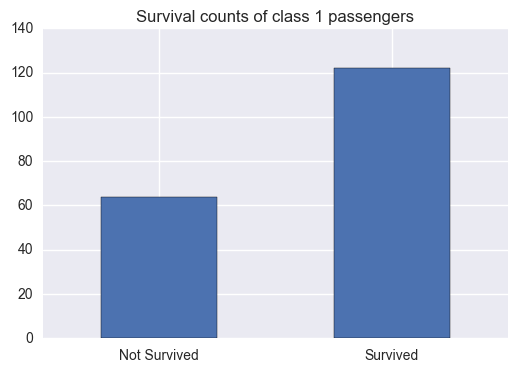

In [222]:
rates = pd.DataFrame(getSurvivalStatByClass(1), index=['Survived', 'Not Survived'], columns=['First Class'])

#### Second Class

Let's first plot how many passengers has survived per classes. 

Survival rate of passengers: 0.479768786127
Desease rate of passengers: 0.520231213873


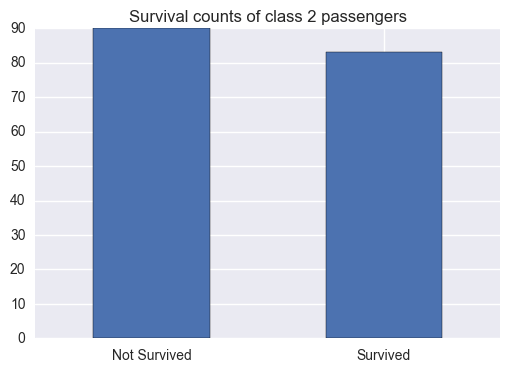

In [223]:
# now we can just call the function defined above
rates['Second Class'] = getSurvivalStatByClass(2)

### Third Class

Survival rate of passengers: 0.239436619718
Desease rate of passengers: 0.760563380282


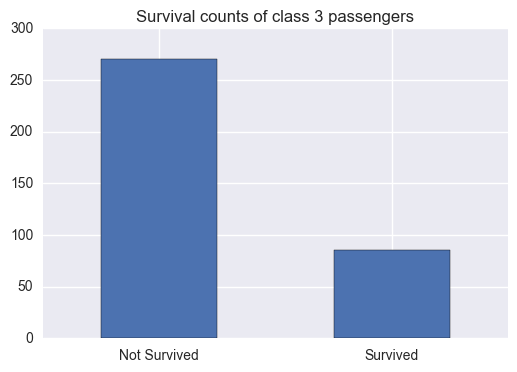

In [224]:
rates['Third Class'] = getSurvivalStatByClass(3)

### Survival rate by Classes

In [225]:
rates

,First Class,Second Class,Third Class
Survived,0.655914,0.479769,0.239437
Not Survived,0.344086,0.520231,0.760563


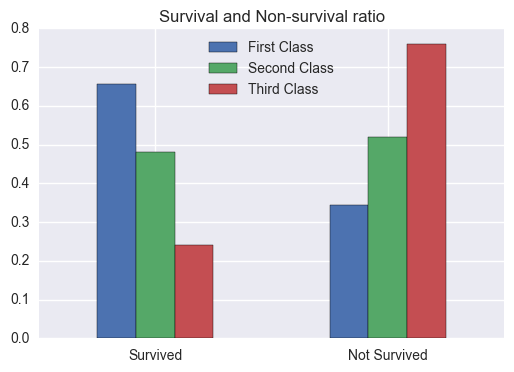

In [226]:
rates.plot.bar(rot=0, title='Survival and Non-survival ratio')

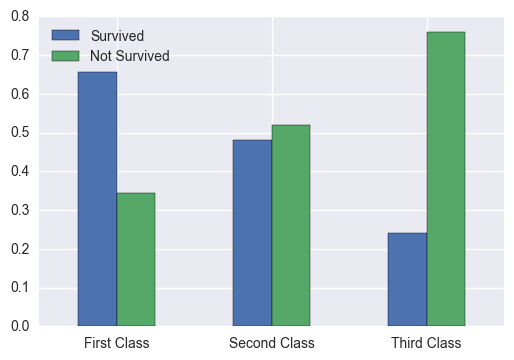

In [227]:
rates.transpose().plot.bar(rot=0)

As the above stats and the chart clearly shows, survival rate tends to decrease as we go lower passenger class, conversly desease rate to increase as we go to lower class. In the first class, about 67% of passengers were survived while only 24% of passengers survived from the third class. In the second class, the ratio between survived passengers and not survived passengers is balanced (0.48 vs. 0.52) compared to the other classes. 

This means the change to survive was higher if one was in the first class as oppose to in the third class (0.66 vs. 0.24). 

## Conclusions
DELETE -  *Has the student correctly communicated tentativeness of findings?*
The results of the analysis are presented such that any limitations are clear. The analysis does not state or imply that one change causes another based solely on a correlation.

